# LSTM based Anomaly Detection

ambient_temperature_system_failure.csv - This dataset has mizture of normal data nad anomalies.

In [1]:
import keras
from keras import optimizers
from keras import losses
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout, Embedding, LSTM
from keras.optimizers import RMSprop, Adam, Nadam
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow 
import sys
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tensorflow.__version__)

Using TensorFlow backend.
C:\Users\kwseow\Anaconda3\envs\prad_gpu01_Py37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\kwseow\Anaconda3\envs\prad_gpu01_Py37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\kwseow\Anaconda3\envs\prad_gpu01_Py37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\kwseo

Python:  3.7.7 (default, May  6 2020, 11:45:54) [MSC v.1916 64 bit (AMD64)]
pandas:  1.0.3
numpy:  1.18.1
seaborn:  0.10.1
matplotlib:  3.1.3
sklearn:  0.22.1
Keras:  2.3.1
Tensorflow:  1.14.0


We will use different examples of time series data to detectwhether a point is normal/expected or abnormal/anomaly.  Let us load the data into a dataframe.

In [2]:
dataFilePaths = ['ambient/ambient_temperature_system_failure_cleaned.csv']
dataFilePath=dataFilePaths[0]
df = pd.read_csv(filepath_or_buffer=dataFilePath, header=0, sep=',')
print('Shape:' , df.shape[0])
print('Head:')
print(df.head(5))

Shape: 7080
Head:
       timestamp      value
0  4/7/2013 0:00  69.880835
1  4/7/2013 1:00  71.220227
2  4/7/2013 2:00  70.877805
3  4/7/2013 3:00  68.959400
4  4/7/2013 4:00  69.283551


Let's plot the time series showing the months on the x-axis and the value on the y-axis.  The original timestamp is a string, so we convert into a datetime type before plotting.

       timestamp      value            Datetime
0  4/7/2013 0:00  69.880835 2013-07-04 00:00:00
1  4/7/2013 1:00  71.220227 2013-07-04 01:00:00
2  4/7/2013 2:00  70.877805 2013-07-04 02:00:00


Text(0.5, 1.0, 'Time Series of value by date time')

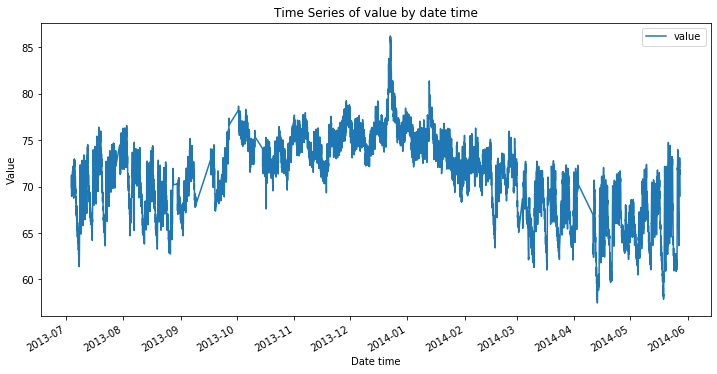

In [3]:
df['Datetime'] = pd.to_datetime(df['timestamp'], format='%d/%m/%Y %H:%M',)
print(df.head(3))
df.shape
df.plot(x='Datetime', y='value', figsize=(12,6))
plt.xlabel('Date time')
plt.ylabel('Value')
plt.title('Time Series of value by date time')

Let's understand the data more.  We run the describe() command to look at the value column.

In [4]:
df.value.describe()

count    7080.000000
mean       71.245959
std         4.261836
min        57.458406
25%        68.376858
50%        71.861331
75%        74.438730
max        86.223213
Name: value, dtype: float64

Let us also port the data using seaborn kde plot.
https://seaborn.pydata.org/generated/seaborn.kdeplot.html

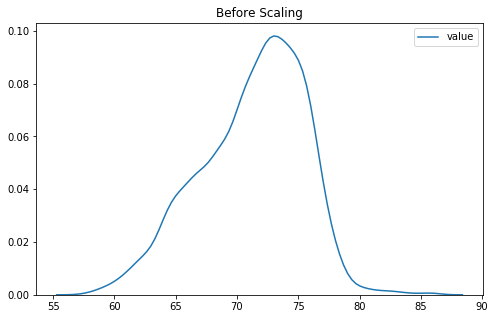

In [5]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(8, 5))
ax1.set_title('Before Scaling')
sns.kdeplot(df['value'], ax=ax1)

The data points have a minimum of 8 and maximum of 39197 which is a wide range.  Let us use scaling to normalize the data.

The formula for scaling is (x-min)/(max-min). However, we will use scikit learn's MinMaxScaler class to do this.  Run the following code to scale the data

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
df['scaled_value'] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df['value'])),columns=['value'])
print('Shape:' , df.shape[0])
df.head(5)

Shape: 7080


,timestamp,value,Datetime,scaled_value
0,4/7/2013 0:00,69.880835,2013-07-04 00:00:00,0.431862
1,4/7/2013 1:00,71.220227,2013-07-04 01:00:00,0.478426
2,4/7/2013 2:00,70.877805,2013-07-04 02:00:00,0.466521
3,4/7/2013 3:00,68.959400,2013-07-04 03:00:00,0.399829
4,4/7/2013 4:00,69.283551,2013-07-04 04:00:00,0.411098


Plot the data again

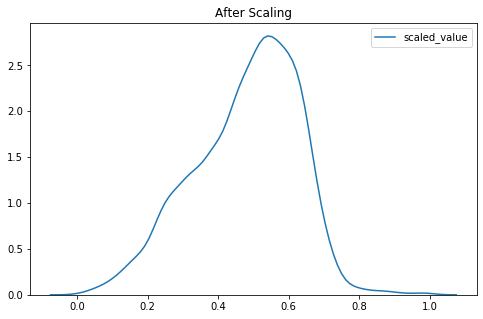

In [7]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(8, 5))
ax1.set_title('After Scaling')
sns.kdeplot(df['scaled_value'], ax=ax1)

TO REWRITE: There are 7080 data points in the sequence and your goal is to find anomalies. This means we are trying to find out when data points are abnormal. If we can predict a data point at time T based on the historical data until T-1, then we have a way of looking at an expected value compared to an actual value to see if we are within the expected range of values for time T. If we predicted that ypred number of taxis are in demand on xxx xx, 20xx, then we can compare this ypred with the actual yactual. The difference between ypred and yactual gives the error, and when we get the errors of all the points in the sequence, we end up with a distribution of just errors.<p>

To accomplish this, we will use a sequential model using Keras. The model consists of a LSTM layer and a dense layer. The LSTM layer takes as input the time series data and learns how to learn the values with respect to time. The next layer is the dense layer (fully connected layer). The dense layer takes as input the output from the LSTM layer, and transforms it into a fully connected manner. Then, we apply a sigmoid activation on the dense layer so that the final output is between 0 and 1. <p>
   
We also use the adam optimizer and the mean squared error as the loss function.
    
<p>
More on LSTM in keras here: https://keras.io/api/layers/recurrent_layers/lstm/
<p>
[This is correct]
    We set a variable time_steps to 24 and pass this as the time_step parameter to LSTM().  This is a number of steps in the sequence that is used in training LSTM.  24, in this case, means 24 hours since our data points are 60 minutes apart.  We can try chaning this to 48 or 72 and see what happends to the output.


In [20]:
time_steps = 24
metric = 'mean_absolute_error'

model = Sequential()
#odel.add(LSTM(units=32, activation='tanh', input_shape=(time_steps, 1), return_sequences=True))
model.add(LSTM(units=32, activation='tanh', input_shape=(time_steps, 1), return_sequences=True))
model.add(LSTM(units=32, activation='tanh', return_sequences=True))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[metric])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 24, 32)            4352      
_________________________________________________________________
lstm_10 (LSTM)               (None, 24, 32)            8320      
_________________________________________________________________
dense_5 (Dense)              (None, 24, 1)             33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________
None


We now split the sequence into a tumbing window of sub-sequences of length 48.  Note the shape of sequence_trammed, which is 215 subsequence of 48 points each with 1 dimension at each point (we only have scaled_value as a column at each time stamp)

In [21]:
sequence = np.array(df['scaled_value'])
print(sequence)
time_steps = 24
samples = len(sequence)
trim = samples % time_steps
subsequences = int(samples/time_steps)
sequence_trimmed = sequence[:samples - trim]

print(samples, subsequences)
sequence_trimmed.shape = (subsequences, time_steps, 1)
print(sequence_trimmed.shape)

[0.43186209 0.47842565 0.46652145 ... 0.4273213  0.42513033 0.40078674]
7080 295
(295, 24, 1)


We are not ready to train our model for 20 epochs, using the training set as the validation data.

In [22]:
training_dataset = sequence_trimmed
print("training_dataset: ", training_dataset.shape)

batch_size=32
epochs=50

model.fit(x=training_dataset, y=training_dataset,
                       batch_size=batch_size, epochs=epochs,
                       verbose=1, validation_data=(training_dataset, training_dataset))

training_dataset:  (295, 24, 1)
Train on 295 samples, validate on 295 samples
Epoch 1/50
295/295 [==============================] - 1s 4ms/step - loss: 0.1177 - mean_absolute_error: 0.1177 - val_loss: 0.1139 - val_mean_absolute_error: 0.1139
Epoch 2/50
295/295 [==============================] - 1s 2ms/step - loss: 0.1126 - mean_absolute_error: 0.1126 - val_loss: 0.1090 - val_mean_absolute_error: 0.1090
Epoch 3/50
295/295 [==============================] - 1s 2ms/step - loss: 0.1056 - mean_absolute_error: 0.1056 - val_loss: 0.0998 - val_mean_absolute_error: 0.0998
Epoch 4/50
295/295 [==============================] - 1s 2ms/step - loss: 0.0927 - mean_absolute_error: 0.0927 - val_loss: 0.0884 - val_mean_absolute_error: 0.0884
Epoch 5/50
295/295 [==============================] - 1s 2ms/step - loss: 0.0843 - mean_absolute_error: 0.0843 - val_loss: 0.0822 - val_mean_absolute_error: 0.0822
Epoch 6/50
295/295 [==============================] - 1s 2ms/step - loss: 0.0785 - mean_absolute_error

295/295 [==============================] - 1s 2ms/step - loss: 0.0196 - mean_absolute_error: 0.0196 - val_loss: 0.0191 - val_mean_absolute_error: 0.0191


Once the model is trained, we can now predict a test dataset that is split into subsequences of the same length (time_steps) as the training datasets.  Once this is done, we can then compute the root mean square err (RMSE)

In [23]:
import math
from sklearn.metrics import mean_squared_error

sequence = np.array(df['scaled_value'])
print(sequence)
time_steps = 24
samples = len(sequence)
trim = samples % time_steps
subsequences = int(samples/time_steps)
sequence_trimmed = sequence[:samples - trim]

print(samples, subsequences)
sequence_trimmed.shape = (subsequences, time_steps, 1)
print(sequence_trimmed.shape)

testing_dataset = sequence_trimmed
print("testing_dataset: ", testing_dataset.shape)

testing_pred = model.predict(x=testing_dataset)
print("testing_pred: ", testing_pred.shape)

testing_dataset = testing_dataset.reshape((testing_dataset.shape[0]*testing_dataset.shape[1]), testing_dataset.shape[2])
print("testing_dataset: ", testing_dataset.shape)

testing_pred = testing_pred.reshape((testing_pred.shape[0]*testing_pred.shape[1]), testing_pred.shape[2])
print("testing_pred: ", testing_pred.shape)
errorsDF = testing_dataset - testing_pred
print(errorsDF.shape)
rmse = math.sqrt(mean_squared_error(testing_dataset, testing_pred))
print('Test RMSE: %.3f' % rmse)

[0.43186209 0.47842565 0.46652145 ... 0.4273213  0.42513033 0.40078674]
7080 295
(295, 24, 1)
testing_dataset:  (295, 24, 1)
testing_pred:  (295, 24, 1)
testing_dataset:  (7080, 1)
testing_pred:  (7080, 1)
(7080, 1)
Test RMSE: 0.033


RMSE is 0.035 which is reasonably low, and this is also evident from the low loass from the training phase after 50 epochs.

Now we can use the predicted dataset and the test dataset to compute the difference as diff, which is then passed through vector norms.  Calculating the length or magnitude of vectors is often required directly as a regularization method in machine learning.  We can then sort the scores/diffs and use a curoff value to pick the threshold.  This obviously can change as per the paramters you choose, particularly the cutoff value (which is 0.999).  

In [24]:
#based on cutoff after sorting errors
dist = np.linalg.norm(testing_dataset - testing_pred, axis=-1)

scores =dist.copy()
print(scores.shape)
scores.sort()
cutoff = int(0.999 * len(scores))
print(cutoff)
#print(scores[cutoff:])
threshold= scores[cutoff]
print(threshold)

(7080,)
7072
0.25469075313204614


You got 0.36863 as the threshold.  Anything above is considered an anomaly.  We plot the testing dataset (Green) and the correspindong predicted data set (red)

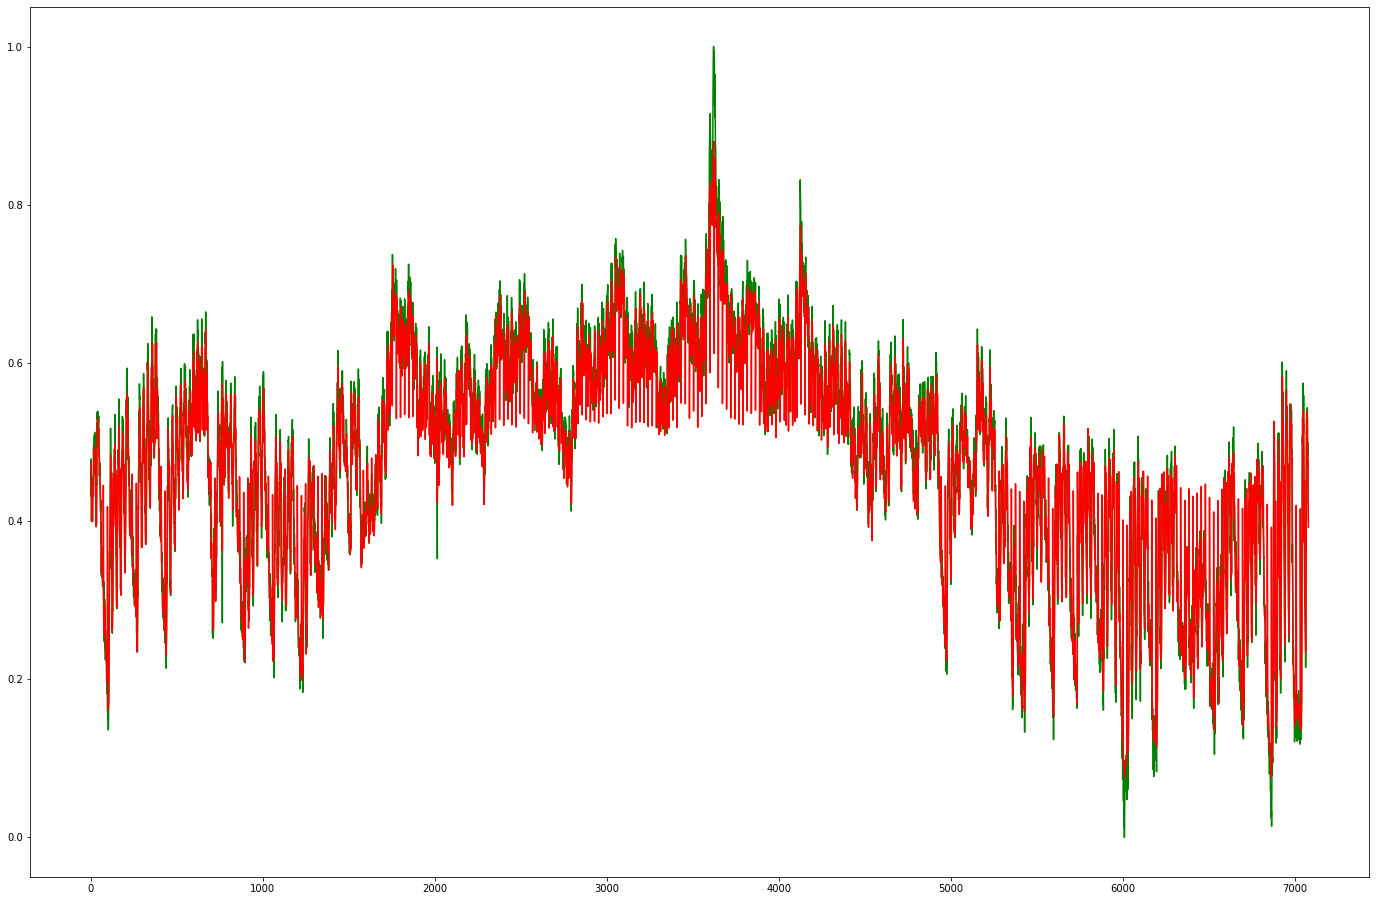

In [25]:
plt.figure(figsize=(24,16))
plt.plot(testing_dataset, color='green')
plt.plot(testing_pred, color='red')

In [26]:
#label the records anomalies or not based on threshold
z = zip(dist >= threshold, dist)

y_label=[]
error = []
for idx, (is_anomaly, dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(dist)
    

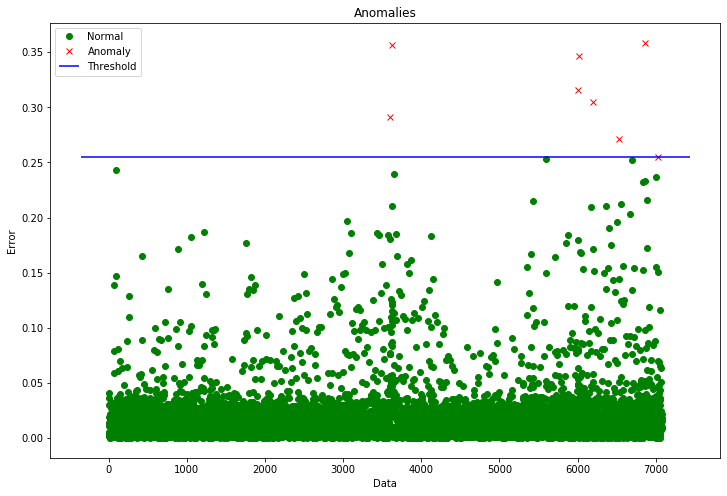

In [27]:
groupsDF = pd.DataFrame({'error': error, 'true': y_label}).groupby('true')

figure, axes = plt.subplots(figsize=(12, 8))

for name, group in groupsDF:
    axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',
        color='r' if name == 1 else 'g', label="Anomaly" if name == 1 else "Normal")

axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
axes.legend()
        
plt.title("Anomalies")
plt.ylabel("Error")
plt.xlabel("Data")
plt.show()

THe following code append the anomaly flag to the dataframe and generate a grpah shoing the anomalies.

In [28]:
adf = pd.DataFrame({'Datetime': df['Datetime'], 'observation': df['scaled_value'],
                    'error': error, 'anomaly': y_label})
adf.head(5)

,Datetime,observation,error,anomaly
0,2013-07-04 00:00:00,0.431862,0.041236,0
1,2013-07-04 01:00:00,0.478426,0.013455,0
2,2013-07-04 02:00:00,0.466521,0.005599,0
3,2013-07-04 03:00:00,0.399829,0.030218,0
4,2013-07-04 04:00:00,0.411098,0.010886,0


Text(0.5, 1.0, 'Time Series of value by date time')

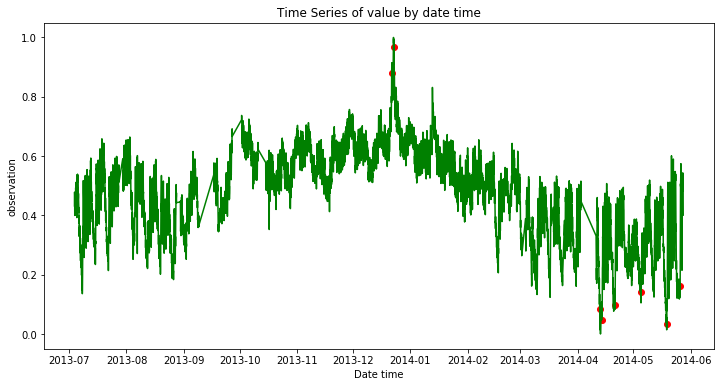

In [29]:
figure, axes = plt.subplots(figsize=(12, 6))
axes.plot(adf['Datetime'], adf['observation'], color='g')
anomaliesDF = adf.query('anomaly == 1')
axes.scatter(anomaliesDF['Datetime'].values, anomaliesDF['observation'], color='r')
plt.xlabel('Date time')
plt.ylabel('observation')
plt.title('Time Series of value by date time')

TO REWRITE:
In the above chart, you can spot an anomaly around Thanskgiving Day, one around New Year Eve, and another one possibly on some snow storm days in January. <p>
    If you play around with some of the prarmeters you used, such as number of time_steps, threshold cutoffs, epochs of the neural network, batch size, and hidden layers, you will see different results.<p>
        A good way to improve the detection is to curate good normal data, use identified anomalies, and put it in the mix to have a way to tune the parameters unril you get food matches on the identified anomalies.